# Imports

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(tf.config.experimental.list_physical_devices('GPU'))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense, GRU
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint

from tqdm import tqdm


2023-01-14 11:20:26.942437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 11:20:27.021320: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-14 11:20:27.419342: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-14 11:20:27.419378: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


2023-01-14 11:20:27.948296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 11:20:27.975077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 11:20:27.975173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Load dataset

In [15]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

X=[]
y=[]

folders = ["nadal", "djoko_sock", "federer", "alcaraz", "dimitrov_alcaraz", "dimitrov_thiem", "roland"]

for folder in folders:
    if not os.path.exists(f"dataset/{folder}/shots/"):
        print(f"dataset/{folder}/shots/ doesnt exist")
        continue
        
    print(f"Loading shots from dataset/{folder}/shots/")
        
    for shot_csv in tqdm(sorted(os.listdir(f'dataset/{folder}/shots/'))):
        data = pd.read_csv(os.path.join(f'dataset/{folder}/shots/', shot_csv))
        
        if folder == "nadal":
            revert_data= data.copy()
            for feature in data.columns:
                if feature[-2:]=="_x":
                    revert_data[feature] = 1 - data[feature]
            data = revert_data

        features = data.loc[:, data.columns != 'shot']

        X.append(features.to_numpy())
        y.append(data["shot"].iloc[0])
    
X = np.stack(X, axis=0)

y = np.array(y)
X = np.array(X)

print(f"Loaded {len(y)} shots for training")

X_test=[]
y_test=[]

folders = ["roland", "alcaraz"]
for folder in folders:
    for shot_csv in sorted(os.listdir(f'dataset/{folder}/shots/')):
    
        data = pd.read_csv(os.path.join(f'dataset/{folder}/shots/',shot_csv ))

        if folder == "dataset_nadal":
                revert_data= data.copy()
                for feature in data.columns:
                    if feature[-2:]=="_x":
                        revert_data[feature] = 1 - data[feature]
                data = revert_data


        features = data.loc[:, data.columns != 'shot']

        X_test.append(features.to_numpy())
        y_test.append(data["shot"].iloc[0])
    
X_test = np.stack(X_test, axis=0)

y_test = np.array(y_test)
X_test = np.array(X_test)

print(f"Loaded {len(y_test)} shots for test")
    

Loading shots from dataset/nadal/shots/


100%|████████████████████████████████████████| 442/442 [00:01<00:00, 376.15it/s]


Loading shots from dataset/djoko_sock/shots/


100%|████████████████████████████████████████| 247/247 [00:00<00:00, 956.12it/s]


Loading shots from dataset/federer/shots/


100%|████████████████████████████████████████| 325/325 [00:00<00:00, 959.46it/s]


Loading shots from dataset/alcaraz/shots/


100%|████████████████████████████████████████| 129/129 [00:00<00:00, 935.44it/s]


Loading shots from dataset/dimitrov_alcaraz/shots/


0it [00:00, ?it/s]


Loading shots from dataset/dimitrov_thiem/shots/


100%|████████████████████████████████████████| 143/143 [00:00<00:00, 925.48it/s]


Loading shots from dataset/roland/shots/


100%|██████████████████████████████████████████| 64/64 [00:00<00:00, 930.88it/s]


Loaded 1350 shots for training
Loaded 193 shots for test


# Display shot repartition

['backhand', 'serve', 'forehand', 'neutral'] [257, 37, 388, 668]


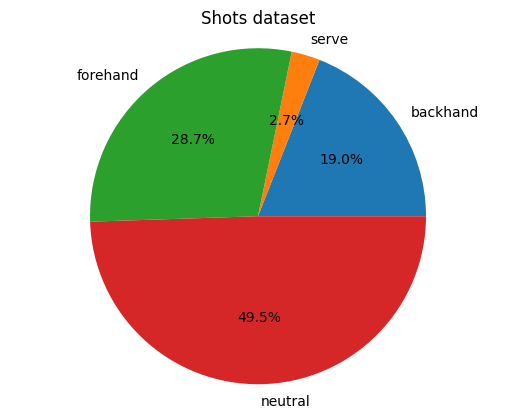

In [16]:
import numpy as np
# if using a Jupyter notebook, include:
%matplotlib inline

shots = list(set(y))
occurences = [np.count_nonzero(y == shot) for shot in shots]
print(shots, occurences)

fig, ax = plt.subplots()
ax.pie(occurences, labels=shots, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Shots dataset')


plt.show()

In [17]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, shuffle= True)


print(f"Shape of train features : {X_train[0].shape}")
print(f"Shape of val features : {X_val[0].shape}")

print("Total categories: ", len(np.unique(y_train)))
print("Total categories: ", len(np.unique(y_val)))

nb_cat = len(np.unique(y_train))

Shape of train features : (30, 26)
Shape of val features : (30, 26)
Total categories:  4
Total categories:  4


In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_cat)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=nb_cat)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=nb_cat)

y_train = np.array(y_train)
X_train = np.array(X_train)
#X_train = np.expand_dims(X_train, axis=-1)

y_val = np.array(y_val)
X_val = np.array(X_val)
#X_val = np.expand_dims(X_val, axis=-1)

y_test = np.array(y_test)
X_test = np.array(X_test)


In [19]:
assert len(le.classes_) == nb_cat

In [20]:
print("X_train Shape: ", X_train.shape)
print("X_val Shape: ", X_val.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_val Shape: ", y_val.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (904, 30, 26)
X_val Shape:  (446, 30, 26)
X_test Shape:  (193, 30, 26)
y_train Shape:  (904, 4)
y_val Shape:  (446, 4)
y_test Shape:  (193, 4)


In [21]:
m1=Sequential()
m1.add(GRU(units=24, dropout=0.1, input_shape=( 30, 26)))
m1.add(Dropout(0.2))
m1.add(Dense(units = 8, activation = 'relu'))
m1.add(Dense(units = nb_cat, activation = 'softmax'))

In [22]:
m1.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
m1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 24)                3744      
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 200       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
Total params: 3,980
Trainable params: 3,980
Non-trainable params: 0
_________________________________________________________________


In [23]:
filepath = "weights.hdf5"
checkpointer = ModelCheckpoint(filepath=filepath, verbose=False, save_best_only=True)
hist = m1.fit(X_train, y_train,
               validation_data=(X_val, y_val),
               batch_size = 32,
                epochs=300, 
                verbose = 1, 
                callbacks=[checkpointer]
             )

loss, accuracy = m1.evaluate(X_val, y_val)
print(f"Accuracy on validation dataset = {accuracy}")

m1.load_weights(filepath)

loss, accuracy = m1.evaluate(X_val, y_val)
print(f"Accuracy on validation dataset = {accuracy}")

Epoch 1/300
29/29 [==============================] - 1s 10ms/step - loss: 1.2973 - accuracy: 0.2799 - val_loss: 1.2048 - val_accuracy: 0.3027
Epoch 2/300
29/29 [==============================] - 0s 3ms/step - loss: 1.2197 - accuracy: 0.3418 - val_loss: 1.1495 - val_accuracy: 0.5314
Epoch 3/300
29/29 [==============================] - 0s 3ms/step - loss: 1.1700 - accuracy: 0.4923 - val_loss: 1.1169 - val_accuracy: 0.4978
Epoch 4/300
29/29 [==============================] - 0s 3ms/step - loss: 1.1371 - accuracy: 0.4923 - val_loss: 1.0873 - val_accuracy: 0.4978
Epoch 5/300
29/29 [==============================] - 0s 4ms/step - loss: 1.1073 - accuracy: 0.4945 - val_loss: 1.0609 - val_accuracy: 0.4978
Epoch 6/300
29/29 [==============================] - 0s 4ms/step - loss: 1.0669 - accuracy: 0.5000 - val_loss: 1.0075 - val_accuracy: 0.5179
Epoch 7/300
29/29 [==============================] - 0s 4ms/step - loss: 1.0061 - accuracy: 0.5542 - val_loss: 0.8866 - val_accuracy: 0.6054
Epoch 8/300


Epoch 59/300
29/29 [==============================] - 0s 3ms/step - loss: 0.3030 - accuracy: 0.8960 - val_loss: 0.1824 - val_accuracy: 0.9395
Epoch 60/300
29/29 [==============================] - 0s 3ms/step - loss: 0.2642 - accuracy: 0.9093 - val_loss: 0.1778 - val_accuracy: 0.9439
Epoch 61/300
29/29 [==============================] - 0s 3ms/step - loss: 0.2461 - accuracy: 0.9137 - val_loss: 0.1932 - val_accuracy: 0.9462
Epoch 62/300
29/29 [==============================] - 0s 3ms/step - loss: 0.2581 - accuracy: 0.9071 - val_loss: 0.2064 - val_accuracy: 0.9327
Epoch 63/300
29/29 [==============================] - 0s 3ms/step - loss: 0.2215 - accuracy: 0.9204 - val_loss: 0.1959 - val_accuracy: 0.9283
Epoch 64/300
29/29 [==============================] - 0s 3ms/step - loss: 0.2383 - accuracy: 0.9159 - val_loss: 0.1625 - val_accuracy: 0.9417
Epoch 65/300
29/29 [==============================] - 0s 3ms/step - loss: 0.2855 - accuracy: 0.8993 - val_loss: 0.1592 - val_accuracy: 0.9484
Epoch 

29/29 [==============================] - 0s 3ms/step - loss: 0.1422 - accuracy: 0.9469 - val_loss: 0.1369 - val_accuracy: 0.9619
Epoch 117/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1815 - accuracy: 0.9358 - val_loss: 0.1648 - val_accuracy: 0.9395
Epoch 118/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1779 - accuracy: 0.9325 - val_loss: 0.1490 - val_accuracy: 0.9484
Epoch 119/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1928 - accuracy: 0.9336 - val_loss: 0.1516 - val_accuracy: 0.9552
Epoch 120/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1444 - accuracy: 0.9613 - val_loss: 0.1241 - val_accuracy: 0.9596
Epoch 121/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1478 - accuracy: 0.9458 - val_loss: 0.1447 - val_accuracy: 0.9484
Epoch 122/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1985 - accuracy: 0.9369 - val_loss: 0.1574 - val_accuracy: 0.9484
Epoch 123/300

29/29 [==============================] - 0s 3ms/step - loss: 0.1140 - accuracy: 0.9613 - val_loss: 0.1057 - val_accuracy: 0.9641
Epoch 174/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1223 - accuracy: 0.9602 - val_loss: 0.1128 - val_accuracy: 0.9664
Epoch 175/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1302 - accuracy: 0.9580 - val_loss: 0.1146 - val_accuracy: 0.9664
Epoch 176/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1200 - accuracy: 0.9624 - val_loss: 0.1250 - val_accuracy: 0.9619
Epoch 177/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1195 - accuracy: 0.9580 - val_loss: 0.1165 - val_accuracy: 0.9552
Epoch 178/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1360 - accuracy: 0.9569 - val_loss: 0.1135 - val_accuracy: 0.9574
Epoch 179/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1458 - accuracy: 0.9569 - val_loss: 0.1129 - val_accuracy: 0.9619
Epoch 180/300

29/29 [==============================] - 0s 3ms/step - loss: 0.1150 - accuracy: 0.9591 - val_loss: 0.1092 - val_accuracy: 0.9664
Epoch 231/300
29/29 [==============================] - 0s 4ms/step - loss: 0.0872 - accuracy: 0.9735 - val_loss: 0.1050 - val_accuracy: 0.9664
Epoch 232/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1000 - accuracy: 0.9624 - val_loss: 0.1219 - val_accuracy: 0.9641
Epoch 233/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0958 - accuracy: 0.9679 - val_loss: 0.1148 - val_accuracy: 0.9664
Epoch 234/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1106 - accuracy: 0.9635 - val_loss: 0.1463 - val_accuracy: 0.9709
Epoch 235/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1240 - accuracy: 0.9569 - val_loss: 0.1175 - val_accuracy: 0.9664
Epoch 236/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1236 - accuracy: 0.9602 - val_loss: 0.1141 - val_accuracy: 0.9619
Epoch 237/300

29/29 [==============================] - 0s 3ms/step - loss: 0.0906 - accuracy: 0.9735 - val_loss: 0.1216 - val_accuracy: 0.9686
Epoch 288/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0953 - accuracy: 0.9679 - val_loss: 0.1151 - val_accuracy: 0.9596
Epoch 289/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0746 - accuracy: 0.9779 - val_loss: 0.1235 - val_accuracy: 0.9664
Epoch 290/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0811 - accuracy: 0.9757 - val_loss: 0.1408 - val_accuracy: 0.9641
Epoch 291/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0767 - accuracy: 0.9701 - val_loss: 0.1194 - val_accuracy: 0.9596
Epoch 292/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0963 - accuracy: 0.9712 - val_loss: 0.1174 - val_accuracy: 0.9641
Epoch 293/300
29/29 [==============================] - 0s 3ms/step - loss: 0.1144 - accuracy: 0.9613 - val_loss: 0.1370 - val_accuracy: 0.9596
Epoch 294/300

In [14]:
m1.save("tennis_rnn_rafa.h5")

# Confusion matrix

In [24]:
loss, accuracy = m1.evaluate(X_test, y_test)
print(f"Accuracy on test dataset = {accuracy:.3f}")

7/7 [==============================] - 0s 2ms/step - loss: 0.1327 - accuracy: 0.9637
Accuracy on test dataset = 0.964


In [25]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn


preds = m1.predict(X_test)
test_predictions = np.argmax(preds, axis=1)


7/7 [==============================] - 0s 2ms/step


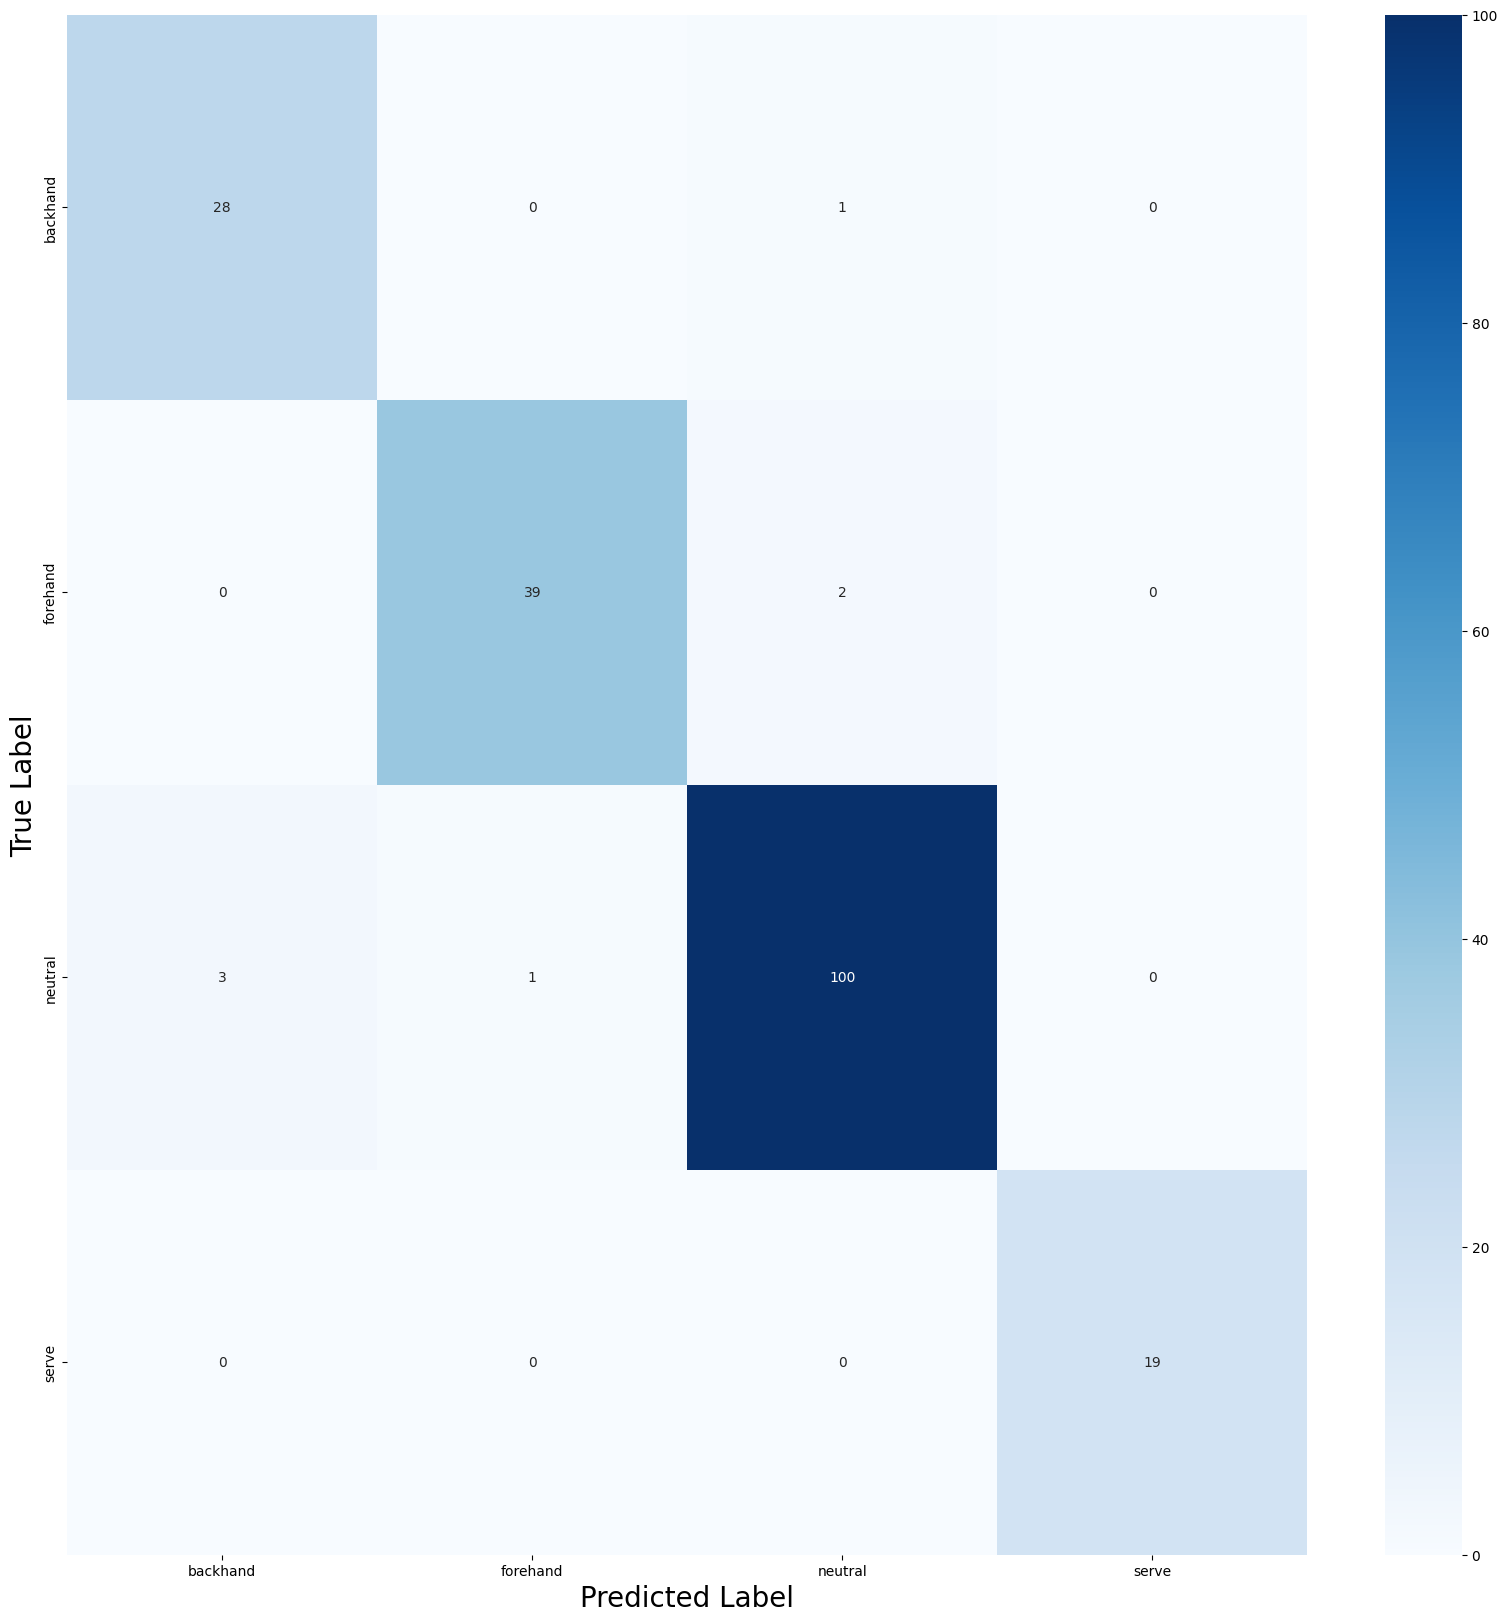

In [26]:
# Plot the confusion matrix
%matplotlib inline


cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=test_predictions)


df_cm = pd.DataFrame(
    cm, index=le.classes_, columns=le.classes_
)
plt.figure(figsize=(20, 20))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.show()

# Display a few examples

In [24]:
import imageio
from tensorflow_docs.vis import embed

def to_gif(shot):
    height = 500
    width = 500
    
    KEYPOINTS = np.array(["nose",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
        "left_hip",
        "right_hip",
        "left_knee",
        "right_knee",
        "left_ankle",
        "right_ankle"])
    
    EDGES = {
        ("nose", "left_shoulder"): "m",
        ("nose", "right_shoulder"): "c",
        ("left_shoulder", "left_elbow"): "m",
        ("left_elbow", "left_wrist"): "m",
        ("right_shoulder", "right_elbow"): "c",
        ("right_elbow", "right_wrist"): "c",
        ("left_shoulder", "right_shoulder"): "y",
        ("left_shoulder", "left_hip"): "m",
        ("right_shoulder", "right_hip"): "c",
        ("left_hip", "right_hip"): "y",
        ("left_hip", "left_knee"): "m",
        ("left_knee", "left_ankle"): "m",
        ("right_hip", "right_knee"): "c",
        ("right_knee", "right_ankle"): "c",
    }
    
    COLORS = {"c": (255, 255, 0), "m": (255, 0, 255), "y": (0, 255, 255)}
    
    
    frames=np.zeros((30, height, width, 3), np.uint8)
    for i in range(len(shot)):
        shot_inst = shot[i, :]
        for k in range(13):
            cv2.circle(
                frames[i],
                (
                    int(shot_inst[2*k+1] * width),
                    int(shot_inst[2*k] * height),
                ),
                radius=3,
                color=(0, 255, 0),
                thickness=-1,
            )
            
        for edge in EDGES.items():
            k = np.argwhere(KEYPOINTS == edge[0][0])[0][0]
            j = np.argwhere(KEYPOINTS == edge[0][1])[0][0]
            cv2.line(
                frames[i],
                (
                    int(shot_inst[2*k+1] * width),
                    int(shot_inst[2*k] * height),
                ),
                (
                    int(shot_inst[2*j+1] * width),
                    int(shot_inst[2*j] * height),
                ),
                color=COLORS[edge[1]],
                thickness=2,
            )
    
    return frames.astype(np.uint8)
        




Predicts:
backhand = 0.4%
forehand = 96.7%
neutral = 2.9%
serve = 0.0%

GT: forehand



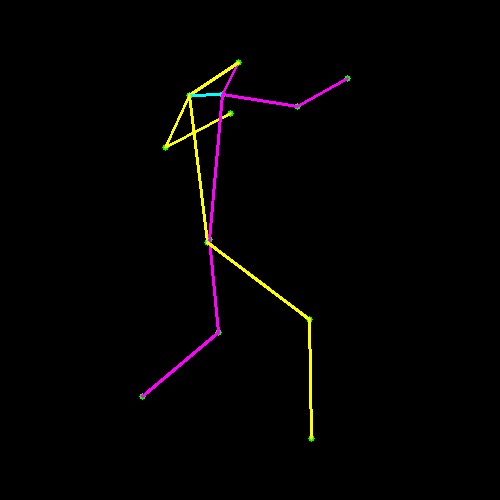

In [25]:
import random
k = random.randint(0, len(y_test))

converted_images = to_gif(X_test[k, :, :])
imageio.mimsave("animation.gif", converted_images, fps=15)

print("Predicts:")
for i in range(nb_cat):
    print(f"{le.classes_[i]} = {preds[k, i]*100:.1f}%")
    

print(f"\nGT: {le.classes_[np.argmax(y_test[k])]}")


embed.embed_file("animation.gif")

## A bad classification

[  0   1   3   4   5   9  13  14  15  16  17  20  22  23  24  27  30  32
  34  35  36  39  48  50  53  54  55  56  57  59  60  61  62  63  64  65
  66  67  68  71  73  74  75  76  77  78  79  80  81  83  84  87  88  89
  93  94  95 120 121 127 128 131 134 137 142 144 148 150 175 192 198 199
 201 203 204 205 206 243 272 296 305 310 338 376 380 383 393 411 412 423
 443 452 454 456 457 463 464 466 469 472 486 488 494 502 504]
30
Predicts:
backhand = 0.9%
forehand = 0.3%
neutral = 97.8%
serve = 1.1%

GT: backhand



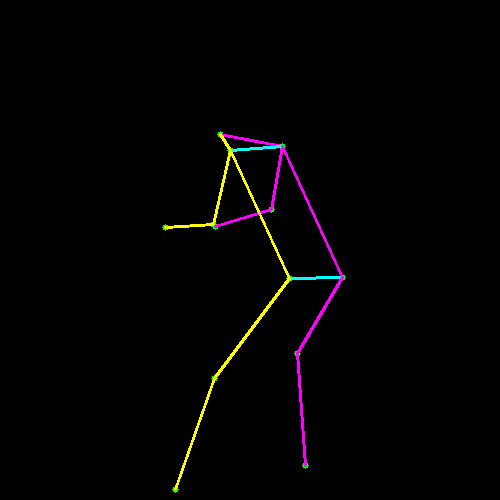

In [173]:
mismatch = np.argwhere(np.argmax(y_test, axis = 1) != test_predictions).flatten()
print(mismatch)

k = mismatch[random.randint(0, len(mismatch) - 1)]

print(k)
converted_images = to_gif(X_test[k, :, :])
imageio.mimsave("animation.gif", converted_images, fps=15)

print("Predicts:")
for i in range(nb_cat):
    print(f"{le.classes_[i]} = {preds[k, i]*100:.1f}%")
    

print(f"\nGT: {le.classes_[np.argmax(y_test[k])]}")


embed.embed_file("animation.gif")